# Welcome to the Credit Risk Analytics Dashboard !

An interactive notebook that allows a user to explore single-name credit risk, portfolio default risk, and system-level sensitivities through a clean and intuitive workflow.

All computations are powered by the backend engine I developed:
Simply choose your input parameters, run the notebook, and the engine handles the rest.

## Dashboard Structure

### **Part 1. - Single-Name Analysis (Merton + CDS)**

Load your list of firms and select one (`FIRM_NAME`) for a detailed investigation.

**The dashboard computes:**
- Structural default probabilities
- CDS-implied intensities
- Monte-Carlo diagnostics (Vₜ paths and terminal distribution) for the chosen company

### **PART 2 - Portfolio Credit Risk (Gaussian & t-copula)**

Using the portfolio CSV, the engine:
- Calibrates hazard rates from CDS spreads
- Builds an equi-correlation matrix
- Simulates correlated defaults using Gaussian and t-copulas
- Produces loss distributions, VaR/ES, and multi-default stress diagnostics

### **PART 3 — Sensitivities & Marginal Risk Contributions**

Re-run the Monte-Carlo engine under modified assumptions:
- Correlation sweeps
- t-copula tail-heaviness changes
- Systemic λ-shocks
- Name-by-name EAD bumps (MCR)

## How to Use

1. **Adjust the config parameters** at the top of the notebook (`FIRM_NAME`, scenario counts, correlation, etc.)

2. **Provide or edit the CSV files** for companies and portfolio

3. **Run all cells** from top to bottom

4. The dashboard automatically generates **all tables, charts, and risk metrics**

# Inputs parameters

In [ ]:
# Data sources
COMPANY_CSV = "./data/company_inputs.csv"      # Used in PART 1 (single-name structural + CDS)
PORTFOLIO_CSV = "./data/portfolio_inputs.csv"  # Used in PART 2 & 3 (portfolio credit risk)

# Part 1. settings
FIRM_NAME = "FirmA"     # Firm analysed in detail in PART 1 (micro diagnostics), can be switched to any name in company_inputs.csv

# Part 2. settings
BASE_RHO = 0.3          # Baseline correlation for portfolio copula model
N_SCENARIOS_PORTFOLIO = 20_000    # MC scenarios for baseline portfolio loss simulation
N_SCENARIOS_COPULA_COMPARE = 20_000   # MC scenarios for Gaussian vs t-copula comparison

# Part 3. settings
N_SCENARIOS_SENSI = 10_000    # MC scenarios for sensitivity analyses (rho, df, lambda shock)

# Global
RANDOM_STATE = 42        # Seed for reproducibility across all Monte-Carlo runs

# Imports

In [ ]:
import os
import sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

PROJECT_ROOT = os.path.abspath("..")
if PROJECT_ROOT not in sys.path:
    sys.path.append(PROJECT_ROOT)

from src.credit_api import (
    compute_structural_pd,
    calibrate_cds_lambda,
    PortfolioParams,
    simulate_portfolio_losses,
    compute_var_es,
)

from src.structural_model import (
    MertonParams,
    structural_pd_monte_carlo,
    structural_pd_closed_form,
)

from src.plotting import (
    plot_asset_distribution,
    plot_pd_comparison,
    plot_loss_distribution,
)

company_df = pd.read_csv("./data/company_inputs.csv")
portfolio_df = pd.read_csv("./data/portfolio_inputs.csv")

print("Company inputs:")
display(company_df)

print("Portfolio inputs:")
display(portfolio_df)

Company inputs:


,Name,V0,D,mu,sigma_A,T_struct,spread_bps,maturity_cds,recovery,rate
0,FirmA,100.0,80.0,0.03,0.25,5.0,120.0,5.0,0.4,0.02
1,FirmB,120.0,100.0,0.03,0.30,5.0,200.0,5.0,0.4,0.02


Portfolio inputs:


,Name,EAD,Recovery,Maturity,Spread_bps,Rate
0,FirmA,10000000,0.40,5.0,120.0,0.02
1,FirmB,8000000,0.35,5.0,200.0,0.02
2,FirmC,6000000,0.40,5.0,150.0,0.02
3,FirmD,5000000,0.45,5.0,100.0,0.02
4,FirmE,4000000,0.40,5.0,300.0,0.02


# Part 1. - Single-name credit (Merton Structural & CDS)

*Load your dataset of multiple firms, then select one company (FIRM_NAME in the config parameters above) to analyze in depth. The engine computes both structural default risk (Merton) and CDS-implied intensities,providing first a macro overview for all firms, then a micro diagnostic panel for the selected name.*

## Inputs

**CSV file:** `company_inputs.csv`

**Required columns:** `Name`, `V0`, `D`, `mu`, `sigma_A`, `T_struct`, `spread_bps`, `maturity_cds`, `recovery`, `rate`

**Interactive parameter:** `FIRM_NAME` (defined in config)

## Main Outputs
#### *Macro : (for all firms in the csv)* :
- **Table `company_results`** with per-firm metrics: (`PD_structural`, `Distance_to_default`, `lambda_cds`,`PD_implied_cds`)

#### *Micro (for selected `FIRM_NAME`)* :
- **PD summary** (for the selected firm) : closed-form structural PD, Monte-Carlo terminal PD, and path-based PD : *(validates the consistency between theory and simulation, and highlights early-default risk)*
- **PD(T) curve:** structural vs CDS-implied default probability across maturities : *(shows the structural model’s steeper short-term risk vs market-implied term structure)*


## Secondary Outputs (Micro)

- Distribution of terminal asset values $V_T$ (Monte Carlo) for `FIRM_NAME` : *(reveals where default sits in the tail)*
- Simulated firm value paths $V_t$ illustrating possible trajectoreis for `FIRM_NAME` : *(visualises distance-to-default dynamics under GBM)*


In [46]:
# Structural PD + distance-to-default
results_structural = []
for _, row in company_df.iterrows():
    res = compute_structural_pd(
        V0=row["V0"],
        D=row["D"],
        mu=row["mu"],
        sigma_A=row["sigma_A"],
        T=row["T_struct"],
    )
    results_structural.append(
        {
            "Name": row["Name"],
            "PD_structural": res["pd_structural"],
            "Distance_to_default": res["distance_to_default"],
        }
    )

structural_df = pd.DataFrame(results_structural)

# CDS calibration
results_cds = []
for _, row in company_df.iterrows():
    res = calibrate_cds_lambda(
        spread_bps=row["spread_bps"],
        maturity=row["maturity_cds"],
        recovery=row["recovery"],
        rate=row["rate"],
        payment_frequency=4,
    )
    results_cds.append(
        {
            "Name": row["Name"],
            "lambda_cds": res["lambda"],
            "PD_implied_cds": res["pd_implied"],
        }
    )

cds_df = pd.DataFrame(results_cds)

company_results = company_df.merge(structural_df, on="Name").merge(cds_df, on="Name")

print("(MACRO): Combined company-level results:")
display(company_results)


(MACRO): Combined company-level results:


,Name,V0,D,mu,sigma_A,T_struct,spread_bps,maturity_cds,recovery,rate,PD_structural,Distance_to_default,lambda_cds,PD_implied_cds
0,FirmA,100.0,80.0,0.03,0.25,5.0,120.0,5.0,0.4,0.02,0.349011,0.387991,0.019902,0.094721
1,FirmB,120.0,100.0,0.03,0.30,5.0,200.0,5.0,0.4,0.02,0.436446,0.159986,0.033117,0.152601


(Micro) : Selected firm: FirmA


,Name,V0,D,mu,sigma_A,T_struct,spread_bps,maturity_cds,recovery,rate,PD_structural,Distance_to_default,lambda_cds,PD_implied_cds
0,FirmA,100.0,80.0,0.03,0.25,5.0,120.0,5.0,0.4,0.02,0.349011,0.387991,0.019902,0.094721


=== PD Summary === (FirmA)
Structural PD (closed-form): 0.3490
Structural PD (Monte Carlo): 0.3487
Monte Carlo PD from paths: 0.3498


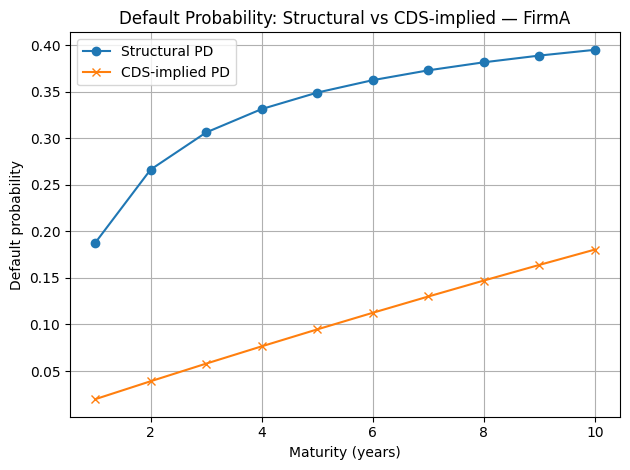

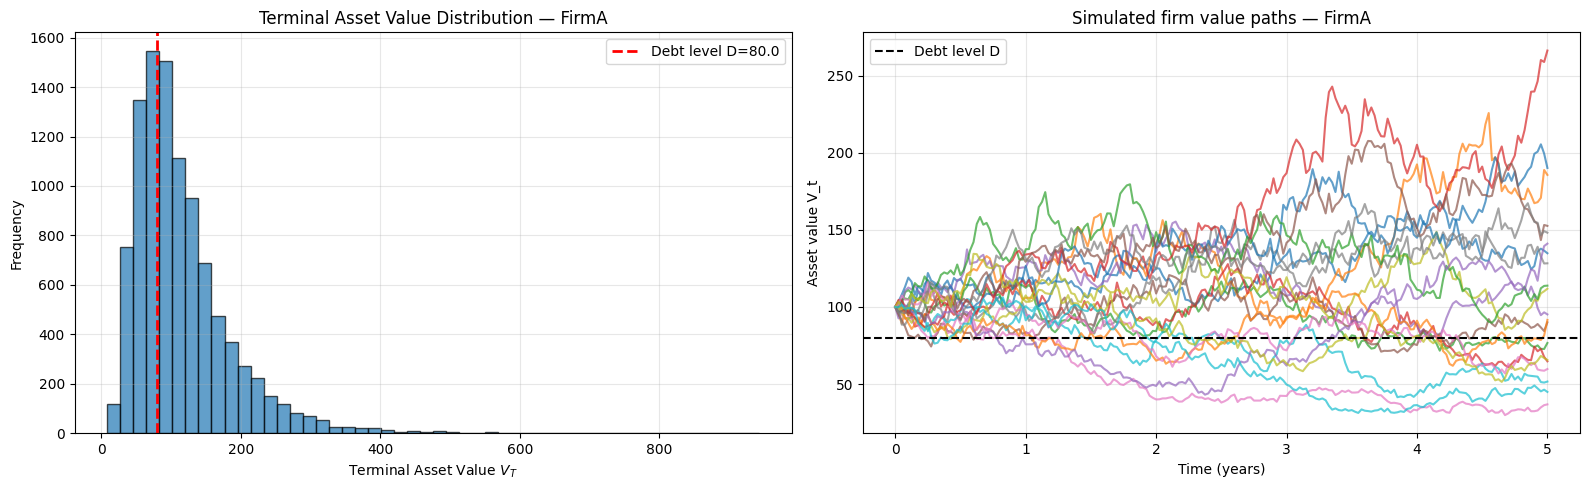

In [52]:
row_firm = company_results.loc[company_results["Name"] == FIRM_NAME].iloc[0]
print(f"(Micro) : Selected firm: {FIRM_NAME}")
display(row_firm.to_frame().T)

lam = row_firm["lambda_cds"]
T_grid = np.linspace(1.0, 10.0, 10)

pd_struct = []
for T in T_grid:
    params = MertonParams(
        V0=row_firm["V0"],
        D=row_firm["D"],
        mu=row_firm["mu"],
        sigma_A=row_firm["sigma_A"],
        T=T,
    )
    pd_struct.append(structural_pd_closed_form(params))

pd_struct = np.array(pd_struct)
pd_cds = 1.0 - np.exp(-lam * T_grid)

plot_pd_comparison(
    maturities=T_grid,
    pd_structural=pd_struct,
    pd_cds=pd_cds,
    title=f"Default Probability: Structural vs CDS-implied — {FIRM_NAME}",
)

params_mc = MertonParams(
    V0=row_firm["V0"],
    D=row_firm["D"],
    mu=row_firm["mu"],
    sigma_A=row_firm["sigma_A"],
    T=row_firm["T_struct"],
    n_paths=10_000,
)

pd_mc, VT = structural_pd_monte_carlo(params_mc, random_state=RANDOM_STATE)
pd_cf = structural_pd_closed_form(params_mc)

print(f"=== PD Summary === ({FIRM_NAME})")
print(f"Structural PD (closed-form): {pd_cf:.4f}")
print(f"Structural PD (Monte Carlo): {pd_mc:.4f}")

# Paths V_t
V0 = row_firm["V0"]
D = row_firm["D"]
mu = row_firm["mu"]
sigma_A = row_firm["sigma_A"]
T = row_firm["T_struct"]

n_paths = 50000
n_steps = 200
dt = T / n_steps
times = np.linspace(0.0, T, n_steps + 1)

rng = np.random.default_rng(RANDOM_STATE)
V_paths = np.zeros((n_paths, n_steps + 1))
V_paths[:, 0] = V0

for k in range(n_steps):
    Z = rng.normal(size=n_paths)
    V_paths[:, k + 1] = V_paths[:, k] * np.exp(
        (mu - 0.5 * sigma_A**2) * dt + sigma_A * np.sqrt(dt) * Z
    )

VT_paths = V_paths[:, -1]
pd_mc_paths = (VT_paths < D).mean()

print(f"Monte Carlo PD from paths: {pd_mc_paths:.4f}")

# Create side-by-side plots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 5))

# Left plot: Asset distribution
ax1.hist(VT, bins=50, alpha=0.7, edgecolor='black')
ax1.axvline(D, color='red', linestyle='--', linewidth=2, label=f'Debt level D={D}')
ax1.set_xlabel('Terminal Asset Value $V_T$')
ax1.set_ylabel('Frequency')
ax1.set_title(f"Terminal Asset Value Distribution — {FIRM_NAME}")
ax1.legend()
ax1.grid(alpha=0.3)

# Right plot: Simulated paths
n_plot = min(20, n_paths)
for i in range(n_plot):
    ax2.plot(times, V_paths[i, :], alpha=0.7)

ax2.axhline(D, color="black", linestyle="--", label="Debt level D")
ax2.set_xlabel("Time (years)")
ax2.set_ylabel("Asset value V_t")
ax2.set_title(f"Simulated firm value paths — {FIRM_NAME}")
ax2.legend()
ax2.grid(alpha=0.3)

plt.tight_layout()
plt.show()


# Part 2. Portfolio credit risk (Copula, VaR, ES, stress)

*Upload your portfolio data and let the engine run Monte-Carlo simulations to reveal how your credit book behaves under correlated default risk: calibrated intensities per name, baseline loss distribution, tail-risk metrics (VaR/ES), stress-level multi-default events, and the full comparison between Gaussian and t-copula scenarios.*

## Inputs

**CSV file:** `portfolio_inputs.csv`

**Required columns:** `Name`, `EAD`, `Recovery`, `Maturity`, `Spread_bps`, `Rate`

**Interactive parameters:** `BASE_RHO`, `N_SCENARIOS_PORTFOLIO`, `N_SCENARIOS_COPULA_COMPARE`

## Main Outputs
**Portfolio calibration**

- Table portfolio_df : spreads → λ : *(Converts each CDS spread into an implied default intensity λ, i.e., the expected default frequency under the model.)*
- Correlation matrix (equi-corr) : *(Defines how strongly defaults move together — higher ρ means more systemic, synchronized default risk.)*

**Gaussian copula (first simulation block) & t-copula (second simulation block)**

- Histogram of losses (df=5 for t-copula : heavy tails) : *(Displays the empirical loss distribution, how often the portfolio loses nothing, something moderate, or suffers large shocks.)*
- VaR 99% and ES 97.5% : *(VaR = the loss level exceeded in only 1% of scenarios; ES = the average loss within the worst 2.5% scenarios. Together they quantify extreme downside risk.)*
- Default clustering (≥3 defaults) : *(Measures how frequently multiple obligors default together, a key marker of systemic contagion.)*
- Extreme-scenario loss statistics : *(Summarizes the losses in the worst simulations, showing how severe the tail becomes under each copula.)*

## Secondary Outputs

Comparative analysis of Gaussian vs t-copula, highlighting tail-risk amplification, increased frequency of multi-default scenarios, and differences in distribution characteristics (mean, variance, quantiles).


In [7]:
lambda_list = []
for _, row in portfolio_df.iterrows():
    res = calibrate_cds_lambda(
        spread_bps=row["Spread_bps"],
        maturity=row["Maturity"],
        recovery=row["Recovery"],
        rate=row["Rate"],
        payment_frequency=4,
    )
    lambda_list.append(res["lambda"])

portfolio_df["lambda"] = lambda_list

print("Portfolio data with calibrated lambda:")
display(portfolio_df)

ead = portfolio_df["EAD"].values
recovery = portfolio_df["Recovery"].values
maturity = portfolio_df["Maturity"].values
lam = portfolio_df["lambda"].values

n_names = len(portfolio_df)

rho = BASE_RHO
corr = np.full((n_names, n_names), rho)
np.fill_diagonal(corr, 1.0)

print("Correlation matrix (equi-corr):")
print(corr)


Portfolio data with calibrated lambda:


,Name,EAD,Recovery,Maturity,Spread_bps,Rate,lambda
0,FirmA,10000000,0.40,5.0,120.0,0.02,0.019902
1,FirmB,8000000,0.35,5.0,200.0,0.02,0.030579
2,FirmC,6000000,0.40,5.0,150.0,0.02,0.024863
3,FirmD,5000000,0.45,5.0,100.0,0.02,0.018097
4,FirmE,4000000,0.40,5.0,300.0,0.02,0.049575


Correlation matrix (equi-corr):
[[1.  0.3 0.3 0.3 0.3]
 [0.3 1.  0.3 0.3 0.3]
 [0.3 0.3 1.  0.3 0.3]
 [0.3 0.3 0.3 1.  0.3]
 [0.3 0.3 0.3 0.3 1. ]]


=== Gaussian copula ===
count    2.000000e+04
mean     2.559918e+06
std      3.777891e+06
min      0.000000e+00
25%      0.000000e+00
50%      0.000000e+00
75%      5.150000e+06
max      1.995000e+07
dtype: float64
_______________________________________________________

VaR 99% : 14800000.00
ES  97.5% : 15522200.00
_______________________________________________________

Number of scenarios with >= 3 defaults: 1121 / 20000
_______________________________________________________
Extreme loss stats (Gaussian):

count    1.121000e+03
mean     1.301160e+07
std      2.754835e+06
min      8.750000e+06
25%      1.120000e+07
50%      1.200000e+07
75%      1.475000e+07
max      1.995000e+07
dtype: float64


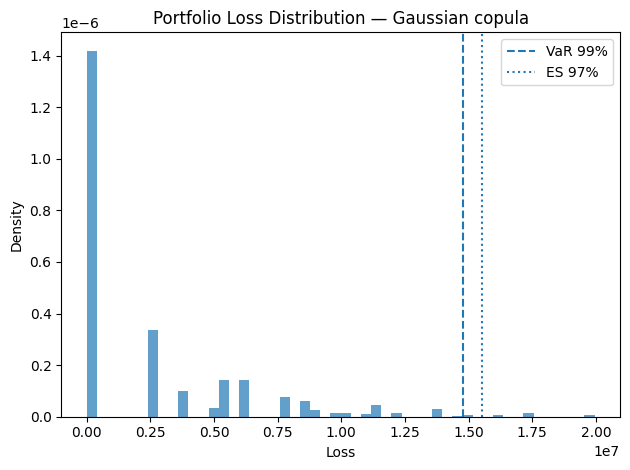

In [25]:
# === Gaussian copula ===
port_gauss = PortfolioParams(
    ead=ead,
    recovery=recovery,
    maturity=maturity,
    lam=lam,
    corr=corr,
    copula_type="gaussian",
    df=5,  # ignored for Gaussian
    n_scenarios=N_SCENARIOS_PORTFOLIO,
)

res_gauss = simulate_portfolio_losses(port_gauss, random_state=RANDOM_STATE)
losses_gauss = res_gauss["losses"]
tau_gauss = res_gauss["tau"]

risk_gauss = compute_var_es(losses_gauss, alpha_var=0.99, alpha_es=0.975)

# Plot
plot_loss_distribution(
    losses_gauss,
    var_level=0.99,
    es_level=0.975,
    var_value=risk_gauss["var"],
    es_value=risk_gauss["es"],
    title="Portfolio Loss Distribution — Gaussian copula",
)

# Numeric summary + stress info 
print("=== Gaussian copula ===")
print(pd.Series(losses_gauss).describe())
print(f"_______________________________________________________\n\nVaR 99% : {risk_gauss['var']:.2f}")
print(f"ES  97.5% : {risk_gauss['es']:.2f}")

default_before_maturity_gauss = tau_gauss < maturity.reshape(1, -1)
n_defaults_per_scenario_gauss = default_before_maturity_gauss.sum(axis=1)

extreme_threshold = 3
extreme_mask_gauss = n_defaults_per_scenario_gauss >= extreme_threshold

n_extreme_gauss = extreme_mask_gauss.sum()
print(f"_______________________________________________________\n\nNumber of scenarios with >= {extreme_threshold} defaults: {n_extreme_gauss} / {len(losses_gauss)}")

if n_extreme_gauss > 0:
    extreme_losses_gauss = losses_gauss[extreme_mask_gauss]
    print("_______________________________________________________\nExtreme loss stats (Gaussian):\n")
    print(pd.Series(extreme_losses_gauss).describe())

=== t-copula (df=5) ===
count    2.000000e+04
mean     2.468712e+06
std      3.900929e+06
min      0.000000e+00
25%      0.000000e+00
50%      0.000000e+00
75%      3.600000e+06
max      1.995000e+07
dtype: float64
_______________________________________________________

VaR 99%   : 17200000.00
ES  97.5% : 16330800.00
_______________________________________________________

Number of scenarios with >= 3 defaults (t-copula): 1215 / 20000
_______________________________________________________
Extreme loss stats (t-copula):

count    1.215000e+03
mean     1.340782e+07
std      2.992376e+06
min      8.750000e+06
25%      1.120000e+07
50%      1.360000e+07
75%      1.480000e+07
max      1.995000e+07
dtype: float64


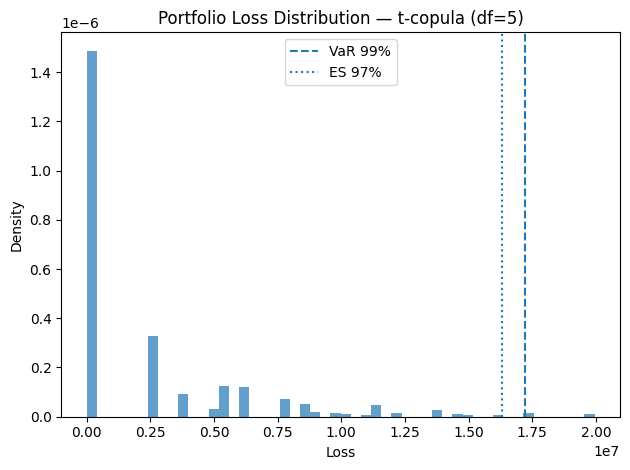

In [ ]:
# === t-copula ===
port_t = PortfolioParams(
    ead=ead,
    recovery=recovery,
    maturity=maturity,
    lam=lam,
    corr=corr,
    copula_type="t",
    df=5,  # low df = heavier tails
    n_scenarios=N_SCENARIOS_COPULA_COMPARE,
)

res_t = simulate_portfolio_losses(port_t, random_state=RANDOM_STATE + 1)
losses_t = res_t["losses"]
tau_t = res_t["tau"]

risk_t = compute_var_es(losses_t, alpha_var=0.99, alpha_es=0.975)

# Plot
plot_loss_distribution(
    losses_t,
    var_level=0.99,
    es_level=0.975,
    var_value=risk_t["var"],
    es_value=risk_t["es"],
    title="Portfolio Loss Distribution — t-copula (df=5)",
)

# Numeric summary + stress info
print("=== t-copula (df=5) ===")
print(pd.Series(losses_t).describe())
print(f"_______________________________________________________\n\nVaR 99%   : {risk_t['var']:.2f}")
print(f"ES  97.5% : {risk_t['es']:.2f}")

default_before_maturity_t = tau_t < maturity.reshape(1, -1)
n_defaults_per_scenario_t = default_before_maturity_t.sum(axis=1)
extreme_mask_t = n_defaults_per_scenario_t >= extreme_threshold
n_extreme_t = extreme_mask_t.sum()

print(f"_______________________________________________________\n\nNumber of scenarios with >= {extreme_threshold} defaults (t-copula): {n_extreme_t} / {len(losses_t)}")

if n_extreme_t > 0:
    extreme_losses_t = losses_t[extreme_mask_t]
    print("_______________________________________________________\nExtreme loss stats (t-copula):\n")
    print(pd.Series(extreme_losses_t).describe())

# Part 3. - Sensitivities & Marginal Contribution to Risk
*Using the same portfolio loaded in Part 2, you can now run this section to observe how your credit book reacts when key risk drivers are perturbed. The Monte-Carlo engine is re-executed under modified assumptions, correlation shifts, t-copula tail-heaviness, λ-shock, EAD bumps, and each sweep triggers a fresh simulation, naturally producing different loss distributions, VaR levels, and default patterns due to MC variability.*

*The shocks used here (+20% on λ, +1% on EAD) are fixed benchmark perturbations: they provide clean and interpretable reference points to measure systemic sensitivity and name-level risk contribution. You may adjust those percentages manually if needed, but they are not interactive controls of the dashboard. The only true interactive parameter in this section is N_SCENARIOS_SENSI, which lets you increase or decrease simulation depth when exploring these sensitivities..*
## Inputs

**CSV:** None (reuses Part 2. portfolio setup)

**Required variables:**
- `ead`, `recovery`, `maturity`, `lam`, `corr`, `n_names`, `risk_gauss`

**Interactive parameter:**
- `N_SCENARIOS_SENSI`

## Main Outputs

**1. VaR 99% sensitivity to correlation ρ**

- *Shows how portfolio risk reacts when correlation increases (ρ = 0 → 0.8). (Detailed sensitivity across multiple correlation levels.)*

**2. VaR 99% sensitivity to t-copula degrees of freedom (df)**

- *Explores how tail risk increases as df decreases (stronger tail dependence). (t-copula tail-behavior exploration.)*

**3. Systemic intensity shock (+20% λ)**

- *Compares baseline VaR vs shocked VaR to quantify systemic stress effects. (Systemic shock impact quantification.)*

**4. Marginal Contribution to VaR (MCR)**

- *Estimates each name's incremental impact on portfolio VaR via a 1% EAD bump. (Name-level risk contribution breakdown.)*

In [ ]:
# 1. VaR vs rho
rhos = [0.0, 0.2, 0.4, 0.6, 0.8]
var_rho = []

for r in rhos:
    corr_test = np.full((n_names, n_names), r)
    np.fill_diagonal(corr_test, 1.0)

    params_rho = PortfolioParams(
        ead=ead,
        recovery=recovery,
        maturity=maturity,
        lam=lam,
        corr=corr_test,
        copula_type="gaussian",
        n_scenarios=N_SCENARIOS_SENSI,
    )
    res = simulate_portfolio_losses(params_rho)
    var_rho.append(compute_var_es(res["losses"])["var"])

var_rho_df = pd.DataFrame({"rho": rhos, "VaR_99": var_rho})
print("1. VaR 99% vs correlation rho:")
display(var_rho_df)

# 2. VaR vs df (t-copula)
dfs = [3, 5, 10, 20, 100]
var_df = []

for df_val in dfs:
    params_t = PortfolioParams(
        ead=ead,
        recovery=recovery,
        maturity=maturity,
        lam=lam,
        corr=corr,
        copula_type="t",
        df=df_val,
        n_scenarios=N_SCENARIOS_SENSI,
    )
    res = simulate_portfolio_losses(params_t)
    var_df.append(compute_var_es(res["losses"])["var"])

var_df_df = pd.DataFrame({"df": dfs, "VaR_99": var_df})
print("_____________________________________________________________________" \
"\n2. VaR 99% vs degrees of freedom (t-copula):")
display(var_df_df)

# 3. Sensitivity: systemic lambda shock (+20%)
lam_shocked = lam * 1.2

params_shock = PortfolioParams(
    ead=ead,
    recovery=recovery,
    maturity=maturity,
    lam=lam_shocked,
    corr=corr,
    copula_type="gaussian",
    n_scenarios=N_SCENARIOS_SENSI,
)

res_shock = simulate_portfolio_losses(params_shock)
risk_shock = compute_var_es(res_shock["losses"])

print("_____________________________________________________________________" \
"\n3. Systemic intensity shock:\n\nVaR 99% (Gaussian, base)  :", risk_gauss["var"])
print("VaR 99% (Gaussian, +20% λ):", risk_shock["var"])

# 4. Marginal Contribution to VaR (1% EAD bump)

mcr = []

for i in range(n_names):
    ead_bumped = ead.copy()
    ead_bumped[i] *= 1.01

    params_mcr = PortfolioParams(
        ead=ead_bumped,
        recovery=recovery,
        maturity=maturity,
        lam=lam,
        corr=corr,
        copula_type="gaussian",
        n_scenarios=N_SCENARIOS_SENSI,
    )
    res = simulate_portfolio_losses(params_mcr)
    var_bumped = compute_var_es(res["losses"])["var"]
    mcr.append(var_bumped - risk_gauss["var"])

mcr_df = pd.DataFrame({"Name": portfolio_df["Name"], "MCR_approx": mcr})
print("\n_____________________________________________________________________" \
"\n4. Marginal Contribution to VaR (MCR):\n\nApproximate Marginal Contribution to VaR (1% EAD bump):")
display(mcr_df)

1. VaR 99% vs correlation rho:


,rho,VaR_99
0,0.0,11200000.0
1,0.2,13950000.0
2,0.4,17200000.0
3,0.6,19950000.0
4,0.8,19950000.0


_____________________________________________________________________
2. VaR 99% vs degrees of freedom (t-copula):


,df,VaR_99
0,3,17200000.0
1,5,17200000.0
2,10,16350000.0
3,20,14800000.0
4,100,16350000.0


_____________________________________________________________________
3. Systemic intensity shock:

VaR 99% (Gaussian, base)  : 14800000.0
VaR 99% (Gaussian, +20% λ): 16350000.0

_____________________________________________________________________
4. Marginal Contribution to VaR (MCR):

Approximate Marginal Contribution to VaR (1% EAD bump):


,Name,MCR_approx
0,FirmA,60000.0
1,FirmB,52000.0
2,FirmC,36000.0
3,FirmD,0.0
4,FirmE,0.0
